<a href="https://colab.research.google.com/github/Saketh-Sundar/covid-forecaster/blob/master/Forecaster_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.linear_model import LassoCV
import datetime as dt
import pandas as pd
import  plotly.express as px 
import plotly.graph_objects as go

#Read US Covid deaths abd filter LA county 
US_Deaths_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'
US_Deaths_df = pd.read_csv(US_Deaths_url, error_bad_lines=True)
US_Deaths_df=US_Deaths_df.drop(columns=['UID','iso2','iso3','code3','Admin2', 'Country_Region','Lat','Long_','Combined_Key'])
US_Deaths_df=US_Deaths_df.dropna(subset=['FIPS'])
US_Deaths_df=US_Deaths_df.melt(id_vars=["FIPS","Population","Province_State"], 
        var_name="Date", 
        value_name="Value")

#Read US Covid cases
Confirmed_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
US_Cases_df = pd.read_csv(Confirmed_url, error_bad_lines=True)
US_Cases_df=US_Cases_df.drop(columns=['UID','iso2','iso3','code3','Admin2', 'Province_State', 'Country_Region','Lat','Long_','Combined_Key'])
US_Cases_df=US_Cases_df.dropna(subset=['FIPS'])
US_Cases_df=US_Cases_df.melt(id_vars=['FIPS'], 
        var_name="Date", 
        value_name="Value")


US_Deaths_df.iloc[:, 3] = pd.to_datetime(US_Deaths_df.iloc[:, 3])
US_Deaths_df.iloc[:, 3]  = (US_Deaths_df.iloc[:, 3]  - US_Deaths_df['Date'].iloc[0]).dt.days
US_Deaths_df = US_Deaths_df.rename(columns={'Date': 'Days', 'Value':'Cumulative_Deaths' })

#US_Deaths_df['Weekly_Deaths'] = US_Deaths_df.groupby(['FIPS', 'Week'])['Cumulative_Deaths'].transform(lambda x: (x.iat[-1] - x.iat[0]))
US_Deaths_df['Weekly_Deaths'] = 0
US_Deaths_df['Weekly_Deaths_Per'] = 0.0
US_Deaths_df = US_Deaths_df.reset_index()
US_Deaths_df.sort_values(by=['FIPS','Days'], inplace=True)
cdArray = US_Deaths_df['Cumulative_Deaths'].to_numpy()
fipsArray = US_Deaths_df['FIPS'].to_numpy()
i =0
 
for index, row in US_Deaths_df.iterrows():
  stateFIPS = row['FIPS']
  if i > 7 and FIPS == stateFIPS and fipsArray[i-7] == FIPS :
    previous_cum_deaths = cdArray[i-7]
    weekly_deaths = row['Cumulative_Deaths'] - previous_cum_deaths
    US_Deaths_df.at[index,'Weekly_Deaths'] =  weekly_deaths
    if previous_cum_deaths  == 0:
      previous_cum_deaths = 1
    US_Deaths_df.at[index, 'Weekly_Deaths_Per'] = (weekly_deaths * 1.0) / (previous_cum_deaths * 1.0)
  else:
    FIPS = stateFIPS  
    US_Deaths_df.at[index,'Weekly_Deaths'] = row['Cumulative_Deaths']
  i = i + 1
 
US_Cases_df.iloc[:, 1] = pd.to_datetime(US_Cases_df.iloc[:, 1])
US_Cases_df.iloc[:, 1]  = (US_Cases_df.iloc[:, 1]  - US_Cases_df['Date'].iloc[0]).dt.days
US_Cases_df = US_Cases_df.rename(columns={'Date': 'Days', 'Value':'Cumulative_Cases'})
US_Cases_df['Weekly_Cases'] = 0
US_Cases_df['Weekly_Cases_Per'] = 0.0
US_Cases_df = US_Cases_df.reset_index()
US_Cases_df.sort_values(by=['FIPS','Days'], inplace=True)
cdArray = US_Cases_df['Cumulative_Cases'].to_numpy()
fipsArray = US_Cases_df['FIPS'].to_numpy()
i =0
 
for index, row in US_Cases_df.iterrows():
  stateFIPS = row['FIPS']
  if i > 7 and FIPS == stateFIPS and fipsArray[i-7] == FIPS :
    previous_cum_cases = cdArray[i-7]
    weekly_cases = row['Cumulative_Cases'] - previous_cum_cases
    US_Cases_df.at[index,'Weekly_Cases'] =  weekly_cases
    if previous_cum_cases  == 0:
      previous_cum_cases = 1
    US_Cases_df.at[index, 'Weekly_Cases_Per'] = (weekly_cases * 1.0) / (previous_cum_cases * 1.0)
  else:
    FIPS = stateFIPS  
    US_Cases_df.at[index,'Weekly_Cases'] = row['Cumulative_Cases']
  i = i + 1



In [ ]:
def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

In [ ]:
#load state tests data to combine with cases and deaths
#data is not available for all days, populate zero for missing ones
from datetime import timedelta, date

state_codes = pd.read_csv('https://docs.google.com/spreadsheets/d/1DAqxIYJdagFN85ncoTQO-CbpJLQECvZWt6qwNMQZUkk/export?format=csv')
start_date = date(2020, 1, 22)
end_date = date.today()

state_codes_date_df = pd.DataFrame({'Date': pd.Series([], dtype='str'),
                   'Code': pd.Series([], dtype='str'),
                   'State': pd.Series([], dtype='str')})
for single_date in daterange(start_date, end_date):
  for index, row in state_codes.iterrows():
    state_codes_date_df = state_codes_date_df.append({'Date': single_date.strftime("%Y%m%d"), 'Code' : row["Code"], 'State' : row["State"]}, ignore_index=True)
state_tests = pd.read_csv("https://covidtracking.com/api/v1/states/daily.csv")
convert_dict = {'date': str} 
state_tests = state_tests.astype(convert_dict)
state_tests_df = state_codes_date_df.merge(state_tests[['date','state','positive', 'negative']],how='left', left_on=['Date', 'Code'], right_on=['date', 'state'])
state_tests_df.sort_values(['Date','State'], inplace=True)
state_tests_df.iloc[:, 0] = pd.to_datetime(state_tests_df.iloc[:, 0],format="%Y%m%d")
state_tests_df.iloc[:, 0]  = (state_tests_df.iloc[:, 0] - state_tests_df['Date'].iloc[0]).dt.days
state_tests_df = state_tests_df.rename(columns={'Date': 'Days'})
state_tests_df['Cumulative_Tests'] = state_tests_df['positive'] + state_tests_df ['negative']
state_tests_df = state_tests_df.drop(columns=['date', 'state', 'positive', 'negative'])
state_tests_df.fillna(0, inplace=True)

In [ ]:
#Read county variates dataset and combine with FIPS, race, icu_beds dataset
county_covariates= pd.read_csv('https://raw.githubusercontent.com/JieYingWu/COVID-19_US_County-level_Summaries/master/data/counties.csv').dropna(subset=['FIPS'])
county_covariates.FIPS = county_covariates.FIPS.astype('int64')
county_covariates=county_covariates.set_index('FIPS')
age_race_df = pd.read_csv('https://docs.google.com/spreadsheets/d/12GIRONjeNHeKFb3EKpo5r-VvdsnTwwe0iOtKBsnZVM0/export?format=csv')
county_icu_beds= pd.read_csv('https://docs.google.com/spreadsheets/d/13iUBUwRcE91_x9FhsF8Ugcb0_tFauWJF2Z-PSkERDlU/export?format=csv')
FIPS = pd.read_csv('https://docs.google.com/spreadsheets/d/1jUwRaTSJ__3Wp60cZLLox5u55mJTZrShtjEK4d7xTEY/export?format=csv')
covariates = age_race_df.merge(county_covariates, how='inner', left_on=["fips"], right_on=['FIPS'])
covariates = covariates.drop(['STNAME', 'County', 'Unnamed: 0','State', 'Area_Name'], axis=1)
covariates = covariates.merge(county_icu_beds, how='inner', left_on=["fips"], right_on=['fips'])
covariates = covariates.drop(['County','State'], axis=1)
#dropping full NaN counties
covariates = covariates[covariates['Jul Temp Max / F'].notnull()]
#merge with US FIPS and makue  sure FIPS are only in the US
US_Deaths_df = US_Deaths_df.merge(FIPS,how='inner', left_on=["FIPS"], right_on=['fips'])
US_Cases_df = US_Cases_df.merge(FIPS,how='inner', left_on=["FIPS"], right_on=['fips'])
list(covariates.columns) 
covariates = covariates.dropna(axis='columns')
list(covariates.columns) 

covariates=covariates[['fips',
 'TOT_POP',
 '0-9',
 '0-9 y/o % of total pop',
 '10-19',
 '10-19 y/o % of total pop',
 '20-29',
 '20-29 y/o % of total pop',
 '30-39',
 '30-39 y/o % of total pop',
 '40-49',
 '40-49 y/o % of total pop',
 '50-59',
 '50-59 y/o % of total pop',
 '60-69',
 '60-69 y/o % of total pop',
 '70-79',
 '70-79 y/o % of total pop',
 '80+',
 '80+ y/o % of total pop',
 'White-alone pop',
 '% White-alone',
 'Black-alone pop',
 '% Black-alone',
 'Native American/American Indian-alone pop',
 '% NA/AI-alone',
 'Asian-alone pop',
 '% Asian-alone',
 'Hawaiian/Pacific Islander-alone pop',
 '% Hawaiian/PI-alone',
 'Two or more races pop',
 '% Two or more races',
 'POP_ESTIMATE_2018',
 'N_POP_CHG_2018',
 'GQ_ESTIMATES_2018',
 'R_birth_2018',
 'R_death_2018',
 'R_NATURAL_INC_2018',
 'R_INTERNATIONAL_MIG_2018',
 'R_DOMESTIC_MIG_2018',
 'R_NET_MIG_2018',
 'Less than a high school diploma 2014-18',
 'High school diploma only 2014-18',
 "Some college or associate's degree 2014-18",
 "Bachelor's degree or higher 2014-18",
 'Percent of adults with less than a high school diploma 2014-18',
 'Percent of adults with a high school diploma only 2014-18',
 "Percent of adults completing some college or associate's degree 2014-18",
 "Percent of adults with a bachelor's degree or higher 2014-18",
 'POVALL_2018',
 'PCTPOVALL_2018',
 'PCTPOV017_2018',
 'PCTPOV517_2018',
 'MEDHHINC_2018',
 'CI90LBINC_2018',
 'CI90UBINC_2018',
 'Civilian_labor_force_2018',
 'Employed_2018',
 'Unemployed_2018',
 'Unemployment_rate_2018',
 'Median_Household_Income_2018',
 'Med_HH_Income_Percent_of_State_Total_2018',
 'Jan Precipitation / inch',
 'Feb Precipitation / inch',
 'Mar Precipitation / inch',
 'Apr Precipitation / inch',
 'May Precipitation / inch',
 'Jun Precipitation / inch',
 'Jul Precipitation / inch',
 'Jan Temp AVG / F',
 'Feb Temp AVG / F',
 'Mar Temp AVG / F',
 'Apr Temp AVG / F',
 'May Temp AVG / F',
 'Jun Temp AVG / F',
 'Jul Temp AVG / F',
 'Active Physicians per 100000 Population 2018 (AAMC)',
 'Total Active Patient Care Physicians per 100000 Population 2018 (AAMC)',
 'Active Primary Care Physicians per 100000 Population 2018 (AAMC)',
 'Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC)',
 'Active General Surgeons per 100000 Population 2018 (AAMC)',
 'Active Patient Care General Surgeons per 100000 Population 2018 (AAMC)',
 'Total nurse practitioners (2019)',
 'Total physician assistants (2019)',
 'Total Hospitals (2019)',
 'Internal Medicine Primary Care (2019)',
 'Family Medicine/General Practice Primary Care (2019)',
 'Total Specialist Physicians (2019)',
 'ICU Beds_x',
 'Total Population',
 'Population Aged 60+',
 'Percent of Population Aged 60+']]
 
#print(covariates)

In [ ]:
#merge us covid deaths and cases with covariates

US_Deaths_Cases_df = US_Deaths_df.merge(US_Cases_df[['Cumulative_Cases', 'Weekly_Cases', 'FIPS', 'Days']], how='inner', left_on=['FIPS', "Days"], right_on=['FIPS', 'Days'])
US_Deaths_Cases_df = US_Deaths_Cases_df.merge(state_tests_df, how='inner', left_on=['Province_State', "Days"], right_on=['State', 'Days'])
covariates_merged = covariates.merge(US_Deaths_Cases_df[['Cumulative_Tests','Cumulative_Cases', 'Weekly_Cases', 'FIPS', 'Days']], how='inner', left_on=["fips"], right_on=['FIPS'])
#dropping NaN columns
covariate_merged = covariates_merged.dropna(axis='columns')
US_Deaths_Cases_df =  US_Deaths_Cases_df.dropna(axis='columns')
fips_state=age_race_df[['STNAME','fips']]
US_Deaths_Cases_df = US_Deaths_Cases_df.merge(fips_state, how='inner', left_on=["FIPS"], right_on=['fips'])
US_Deaths_Cases_df = US_Deaths_Cases_df.drop(columns=['index'])
#pd.set_option('display.max_rows', None)
#corr=covariate_merged.corr()
#print(corr[['Cumulative_Deaths','Daily_Deaths']])

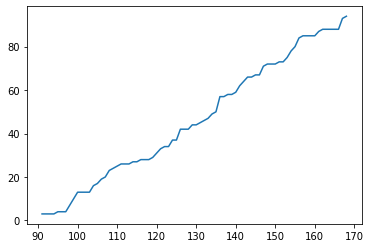

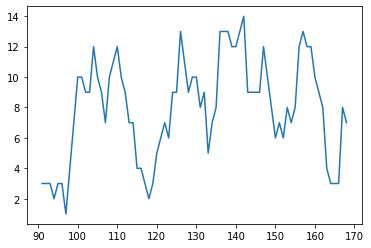

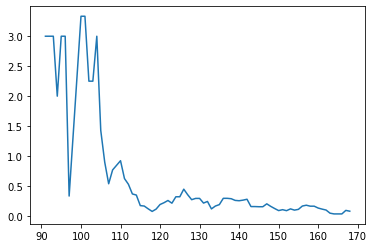

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)
Deaths_Cases_df = US_Deaths_Cases_df[(US_Deaths_Cases_df["FIPS"] == 4015.0) & (US_Deaths_Cases_df["Days"] > 90)]

x = Deaths_Cases_df["Days"]
y = Deaths_Cases_df["Cumulative_Deaths"]
plt.plot(x, y)
plt.show()

y = Deaths_Cases_df["Weekly_Deaths"]
plt.plot(x, y)
plt.show()
y = Deaths_Cases_df["Weekly_Deaths_Per"]
plt.plot(x, y)
plt.show()

In [ ]:
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

min_day=US_Deaths_Cases_df['Days'].min()
max_day=US_Deaths_Cases_df['Days'].max()
countyFIPS = US_Deaths_Cases_df["FIPS"].unique()

num_weeks=int((max_day-min_day)/7)
print("number of weeks : " , num_weeks)
#prediction_days = 7   # one week  train , tune and forecast
prediction_days = 14 # two weks train , tune and forecast
#prediction_days = 14 # three weks train , tune and forecast
#prediction_days = 28 # four weeks train , tune and forecast
day_offset=68


predicted_df_all_days = pd.DataFrame(columns=['State','FIPS', 'Forecast_Day','Days','Predicted_Cumulative_Deaths'])
#i = 0
#iteration = 0 
#index = 0
#tune_forecast_rscores = pd.DataFrame( columns=['week', 'tune_alpha', 'tune_max_r2_score', 'forecast_r2_score'])
#weekly_alpha_rscores = pd.DataFrame( columns=['week', 'alpha', 'r2_score'])
#predict_week_rscores = pd.DataFrame( columns=['week', 'r2_score'])

train_start_week_day = day_offset
train_end_week_day = train_start_week_day + prediction_days
tune_start_week_day = train_end_week_day
tune_end_week_day = train_end_week_day + prediction_days
predict_start_week_day = tune_end_week_day 
predict_end_week_day = tune_end_week_day + prediction_days

for week_num in range(num_weeks):
  if tune_end_week_day > max_day:
    break
  print("train:", train_start_week_day ,":", train_end_week_day, " tune:",  tune_start_week_day,":", tune_end_week_day,
        " predict:" , predict_start_week_day, ":",  predict_end_week_day)
  #print ("training week number: " , week_num+1)
#********************TRAIN MODEL ************************ 
#train with all coutnies variates for one  week  and predict for LA county cumulative deaths
  train_week = pd.Series(range(train_start_week_day,train_end_week_day))
  #print ("training week series :" , train_week.array)
  covariates_train_week = covariates_merged.loc[(covariates_merged['Days'].isin(train_week))] 
  US_Weekly_Deaths_Per = US_Deaths_Cases_df.loc[(US_Deaths_Cases_df['Days'].isin(train_week))].iloc[:, 4]  
  if len(US_Weekly_Deaths_Per) == 0:
    continue
  alphas = [.0001,0.001, 0.01, 0.1]

  #train and predict the future week for LA County
  tune_week = pd.Series(range(tune_start_week_day, tune_end_week_day ))
  #print ("tune next week series :" , tune_week.array)

  alpha_with_max_r2score = -1
  max_r2score = -10
  best_reg = None

  #********************VALIDATE MODEL ************************ 
  #test next week/weeks data for various alpha and pick the one with max r score.
  for alpha in alphas:
    X_train = covariates_train_week
    Y_train = US_Weekly_Deaths_Per
    #reg = LassoCV(cv=5, random_state=0).fit(X_train, Y_train)
    reg = Lasso(alpha=alpha).fit(X_train, Y_train)
    #reg = ElasticNet(alpha=alpha).fit(X_train, Y_train)
    
    
    X_tune_week = covariates_merged.loc[(covariates_merged['Days'].isin(tune_week))]
    Y_actual_tune_week = US_Deaths_Cases_df.loc[(US_Deaths_Cases_df['Days'].isin(tune_week))].iloc[:, 4]
    #score = reg.score(X_tune_week, Y_actual_tune_week)
    Y_tune_week = reg.predict(X_tune_week)
    score = r2_score(Y_actual_tune_week, Y_tune_week)
    #weekly_alpha_rscores.loc[index] = [week_num, alpha,score]
    #index = index + 1
    if score > max_r2score:
      max_r2score = score
      alpha_with_max_r2score = alpha
      best_reg = reg

  #iteration = iteration + 1
  
  #********************FORECAST FUTURE USING MODEL ************************ 
  # take the regression with best r score and predict nex week
  if best_reg:
    predict_week = pd.Series(range(predict_start_week_day, predict_end_week_day ))
    #print ("predicting next week series :" , predict_week.array)
  
    X_predict_week = covariates_merged.loc[(covariates_merged['Days'].isin(predict_week))]
    predict_week_df = US_Deaths_Cases_df.loc[(US_Deaths_Cases_df['Days'].isin(predict_week))]
    Y_actual_predict_week = predict_week_df.iloc[:,4]
    Y_predict_week = best_reg.predict(X_predict_week)
    predict_score = r2_score(Y_actual_predict_week, Y_predict_week)
  
    predicted_df = pd.DataFrame(columns=['State','FIPS', 'Forecast_Day','Days','Predicted_Cumulative_Deaths'])
    predicted_df["State"] = predict_week_df["STNAME"]
    predicted_df["FIPS"] = predict_week_df["FIPS"]
    predicted_df["Days"] = predict_week_df["Days"]
    predicted_df["Forecast_Day"] = predict_start_week_day-1
    predicted_df["Predicted_Cumulative_Deaths"] = Y_predict_week
    predicted_df_all_days = pd.concat([predicted_df_all_days, predicted_df])

    print(week_num , ":",  alpha_with_max_r2score , ":", max_r2score, ":", predict_score)
  
    #tune_forecast_rscores.loc[iteration] = [week_num,alpha_with_max_r2score,  max_r2score, predict_score]
    #predict_week_rscores.loc[iteration] = [week_num,  predict_score]m

  #start_week_day = start_week_day + 14
 
  train_start_week_day = train_start_week_day + prediction_days
  train_end_week_day = train_end_week_day + prediction_days
  tune_start_week_day = train_end_week_day
  tune_end_week_day = train_end_week_day + prediction_days
  predict_start_week_day = tune_end_week_day
  predict_end_week_day = tune_end_week_day + prediction_days
  

number of weeks :  24
train: 61 : 75  tune: 75 : 89  predict: 89 : 103
0 : 0.0001 : 0.9239999945365662 : 0.8959095138183837
train: 75 : 89  tune: 89 : 103  predict: 103 : 117
1 : 0.0001 : 0.9552271567386257 : 0.9426753773983096
train: 89 : 103  tune: 103 : 117  predict: 117 : 131
2 : 0.0001 : 0.9620937742561327 : 0.9495504570591378
train: 103 : 117  tune: 117 : 131  predict: 131 : 145
3 : 0.01 : 0.9643190092820855 : 0.9491098540555639
train: 117 : 131  tune: 131 : 145  predict: 145 : 159
4 : 0.01 : 0.9638103195460895 : 0.9427968984040346
train: 131 : 145  tune: 145 : 159  predict: 159 : 173
5 : 0.1 : 0.9646757763519289 : 0.9371278183029936


In [ ]:
import datetime

data_start_date = datetime.datetime.strptime("01/22/20", "%m/%d/%y")
state_predicted_deaths = predicted_df_all_days.groupby(['State', 'Days', 'Forecast_Day'], as_index=False)[["Predicted_Cumulative_Deaths"]].sum()
state_to_fips=pd.read_csv('https://docs.google.com/spreadsheets/d/1w4sHgYifJV-C8J1WV5rpTzEFLuyZ5ESp8r_1ck-9hlA/export?format=csv')
state_predicted_deaths = state_predicted_deaths.merge(state_to_fips, how='left', left_on=['State'], right_on=['Name'])
state_predicted_deaths=state_predicted_deaths.drop(columns=['Name'])
country_predicted_deaths = predicted_df_all_days.groupby(['Days', 'Forecast_Day'], as_index=False)[["Predicted_Cumulative_Deaths"]].sum()

state_predicted_deaths=state_predicted_deaths[['State','FIPS','Days','Forecast_Day','Predicted_Cumulative_Deaths']]
covid_hub_predicted_deaths = pd.DataFrame(columns=['forecast_date','target', 'target_end_date','location', 'location_name','type', 'quantile', 'value'])
iteration = 0  

for index, row in country_predicted_deaths.iterrows():
    covid_hub_predicted_deaths.loc[iteration,"location"] = 'US'
    covid_hub_predicted_deaths.loc[iteration,"location_name"] = 'US'
    #predicted_df["FIPS"] = predict_week_df["FIPS"]
    #predicted_df["Days"] = predict_week_df["Days"]
    target_date = (data_start_date + datetime.timedelta(days=row["Days"]))
    days_from = str(row["Days"] - row["Forecast_Day"])
    covid_hub_predicted_deaths.loc[iteration,"target"] = days_from + " day ahead cum death"
    covid_hub_predicted_deaths.loc[iteration,"target_end_date"] = target_date.strftime("%Y-%m-%d")
    covid_hub_predicted_deaths.loc[iteration,"forecast_date"] =  (data_start_date + datetime.timedelta(days=row["Forecast_Day"])).strftime("%Y-%m-%d")
    covid_hub_predicted_deaths.loc[iteration,"type"] ="point"
    covid_hub_predicted_deaths.loc[iteration,"quantile"] ="NA"
    if row["Predicted_Cumulative_Deaths"] >= 0:
      covid_hub_predicted_deaths.loc[iteration,"value"] = row["Predicted_Cumulative_Deaths"]
    else:
      covid_hub_predicted_deaths.loc[iteration,"value"] = 0

    iteration = iteration + 1

for index, row in state_predicted_deaths.iterrows():
    covid_hub_predicted_deaths.loc[iteration,"location"] = str(row["FIPS"]).zfill(2)
    covid_hub_predicted_deaths.loc[iteration,"location_name"] = row["State"]
    #predicted_df["FIPS"] = predict_week_df["FIPS"]
    #predicted_df["Days"] = predict_week_df["Days"]
    target_date = (data_start_date + datetime.timedelta(days=row["Days"]))
    days_from = str(row["Days"] - row["Forecast_Day"])
    covid_hub_predicted_deaths.loc[iteration,"target"] = days_from + " day ahead cum death"
    covid_hub_predicted_deaths.loc[iteration,"target_end_date"] = target_date.strftime("%Y-%m-%d")
    covid_hub_predicted_deaths.loc[iteration,"forecast_date"] =  (data_start_date + datetime.timedelta(days=row["Forecast_Day"])).strftime("%Y-%m-%d")
    covid_hub_predicted_deaths.loc[iteration,"type"] ="point"
    covid_hub_predicted_deaths.loc[iteration,"quantile"] ="NA"
    if row["Predicted_Cumulative_Deaths"] >= 0:
      covid_hub_predicted_deaths.loc[iteration,"value"] = row["Predicted_Cumulative_Deaths"]
    else:
      covid_hub_predicted_deaths.loc[iteration,"value"] = 0
    iteration = iteration + 1
print(covid_hub_predicted_deaths)
from google.colab import files
covid_hub_predicted_deaths.to_csv("covid_us_states_predicted_deaths_thp.csv")
files.download("covid_us_states_predicted_deaths_thp.csv")


     forecast_date                   target target_end_date location  \
0       2020-04-19  1.0 day ahead cum death      2020-04-20       US   
1       2020-04-19  2.0 day ahead cum death      2020-04-21       US   
2       2020-04-19  3.0 day ahead cum death      2020-04-22       US   
3       2020-04-19  4.0 day ahead cum death      2020-04-23       US   
4       2020-04-19  5.0 day ahead cum death      2020-04-24       US   
...            ...                      ...             ...      ...   
3995    2020-06-28    6 day ahead cum death      2020-07-04       56   
3996    2020-06-28    7 day ahead cum death      2020-07-05       56   
3997    2020-06-28    8 day ahead cum death      2020-07-06       56   
3998    2020-06-28    9 day ahead cum death      2020-07-07       56   
3999    2020-06-28   10 day ahead cum death      2020-07-08       56   

     location_name   type quantile    value  
0               US  point       NA  57776.8  
1               US  point       NA  60098.1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>